# Self-Driving Car Engineer Nanodegree

## Project 5: Vehicle Detection and Tracking

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Defining helper functions for Feature Extraction

Here we define functions for features extraction (HOG, binned color and color histogram features)

In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

### Define Feature Extracter function to extract the hog features, binned color and color histogram features

This method will make use of the above helper functions to extract image features

In [3]:
def extract_features(imgs, cspace='RGB', orient=9,spatial_size=(32, 32),hist_bins=32, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=False, hist_feat=False, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'LAB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            features.append(hog_features)
        
        # Call bin_spatial()
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            features.append(spatial_features)
        
        # Call color_hist()
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            features.append(hist_features)
        
        
    # Return list of feature vectors
    return features

### Load Training Data

Here we create lists of car and non-car images provided by Udacity.

In [4]:
car_images = glob.glob('training/vehicles/**/*.png')
noncar_images = glob.glob('training/non-vehicles/**/*.png')
print("Total Car Images available are :%d "% len(car_images)) 
print("Total Non-Car Images available are :%d "% len(noncar_images))

Total Car Images available are :8792 
Total Non-Car Images available are :8968 


**Since the number of Car Images and Non-Car Images are approximately equal we don't have to do any augumentation to balance the image numbers**

### Visualize Sample Data

Let's Visualize some sample data of cars and non-cars by displaying random images from both classes

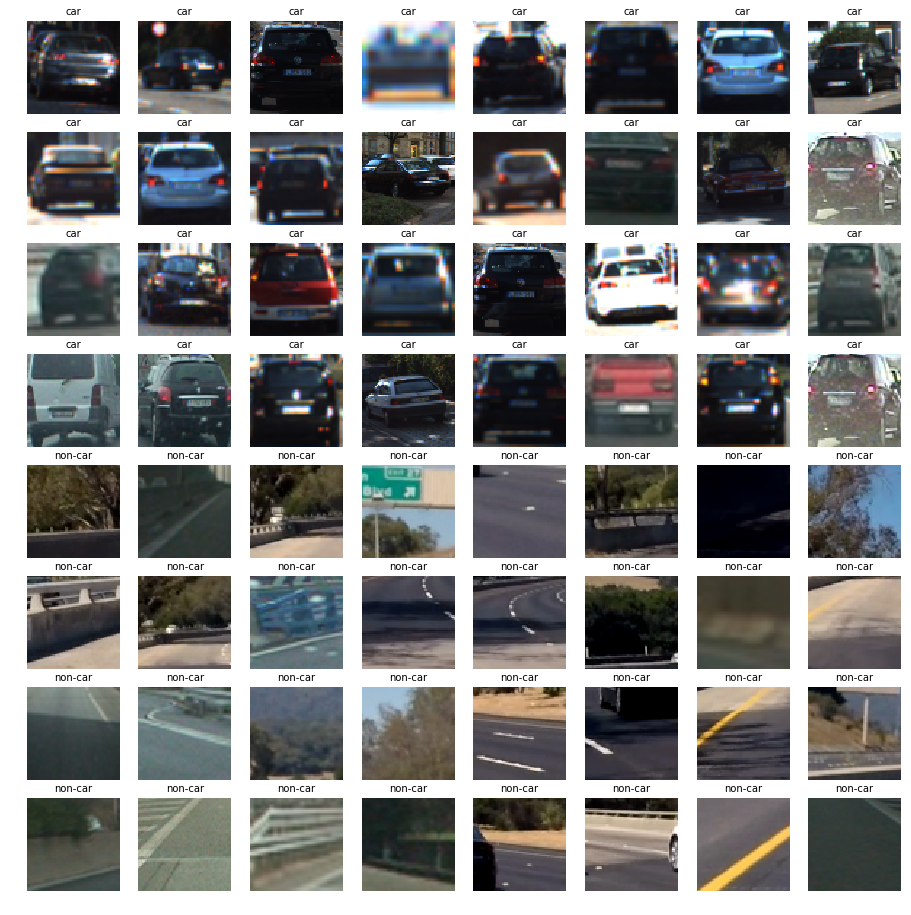

In [5]:
fig, axs = plt.subplots(8,8, figsize=(16, 16))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in np.arange(32):
    img = cv2.imread(car_images[np.random.randint(0,len(car_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(32,64):
    img = cv2.imread(noncar_images[np.random.randint(0,len(noncar_images))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('non-car', fontsize=10)
    axs[i].imshow(img)

### Convert Image to Histogram of Oriented Gradients and Visualize them

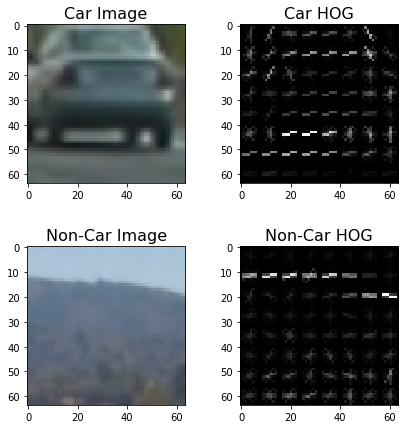

In [6]:
car_img = mpimg.imread(car_images[25])
_, car_dst = get_hog_features(car_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
noncar_img = mpimg.imread(noncar_images[25])
_, noncar_dst = get_hog_features(noncar_img[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Visualize 
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7,7))
f.subplots_adjust(hspace = .4, wspace=.2)
ax1.imshow(car_img)
ax1.set_title('Car Image', fontsize=16)
ax2.imshow(car_dst, cmap='gray')
ax2.set_title('Car HOG', fontsize=16)
ax3.imshow(noncar_img)
ax3.set_title('Non-Car Image', fontsize=16)
ax4.imshow(noncar_dst, cmap='gray')
ax4.set_title('Non-Car HOG', fontsize=16)

### Extract Features for Input Datasets and Combine, Define Labels Vector, Shuffle and Split

Initially I will test for the time taken of Feature Extraction for different combinations of Color space, Orientation and Pixels per cell with a sample of first 100 car and non-car images. Then I will take from each color space one combination that takes moderate amount of time and one combination the takes least amount of time to extract the features and will try them to find the best possible training accuracy and training time to pick one possible combination that I think will work fine for the Vehicle detection and Tracking pipeline.

In [7]:
# Feature extraction parameters
for cspc in ['RGB','HSV','LUV','HLS','YUV','YCrCb','LAB']:
    for ornt in range(8,12):
        for pxpc in range(4,20,4):
        
            colorspace = cspc # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
            orient = ornt
            pix_per_cell = pxpc
            cell_per_block = 2
            spatial_size=(32, 32)
            hist_bins=32
            hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
            hog_feat = True
            spatial_feat=False
            hist_feat=False


            t = time.time()
            car_features = extract_features(car_images[0:100], cspace=colorspace, orient=orient, spatial_size = spatial_size, 
                                    hist_bins=hist_bins,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
            notcar_features = extract_features(noncar_images[0:100], cspace=colorspace, orient=orient, spatial_size = spatial_size,
                                    hist_bins=hist_bins,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
            t2 = time.time()
            print(round(t2-t, 2), 'Seconds to extract HOG features...')
            # Create an array stack of feature vectors
            X = np.vstack((car_features, notcar_features)).astype(np.float64)  

            # Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
            #X_scaler = StandardScaler().fit(X)
            # Apply the scaler to X
            #scaled_X = X_scaler.transform(X)

            # Define the labels vector
            y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


            # Split up data into randomized training and test sets
            rand_state = np.random.randint(0, 100)
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=rand_state)

            print('Using: ',cspc,' Color space',orient,' orientations',pix_per_cell,
                ' pixels per cell and', cell_per_block,'cells per block')
            print('Feature vector length:', len(X_train[0]))

4.15 Seconds to extract HOG features...
Using:  RGB  Color space 8  orientations 4  pixels per cell and 2 cells per block
Feature vector length: 21600
1.12 Seconds to extract HOG features...
Using:  RGB  Color space 8  orientations 8  pixels per cell and 2 cells per block
Feature vector length: 4704
0.76 Seconds to extract HOG features...
Using:  RGB  Color space 8  orientations 12  pixels per cell and 2 cells per block
Feature vector length: 1536
0.76 Seconds to extract HOG features...
Using:  RGB  Color space 8  orientations 16  pixels per cell and 2 cells per block
Feature vector length: 864
3.23 Seconds to extract HOG features...
Using:  RGB  Color space 9  orientations 4  pixels per cell and 2 cells per block
Feature vector length: 24300
1.24 Seconds to extract HOG features...
Using:  RGB  Color space 9  orientations 8  pixels per cell and 2 cells per block
Feature vector length: 5292
0.83 Seconds to extract HOG features...
Using:  RGB  Color space 9  orientations 12  pixels per c

Using:  LAB  Color space 11  orientations 4  pixels per cell and 2 cells per block
Feature vector length: 29700
1.5 Seconds to extract HOG features...
Using:  LAB  Color space 11  orientations 8  pixels per cell and 2 cells per block
Feature vector length: 6468
0.81 Seconds to extract HOG features...
Using:  LAB  Color space 11  orientations 12  pixels per cell and 2 cells per block
Feature vector length: 2112
0.8 Seconds to extract HOG features...
Using:  LAB  Color space 11  orientations 16  pixels per cell and 2 cells per block
Feature vector length: 1188


Going through the above observations, I have considered the following combinations to check for Training accuracy and speed

-----------------------------------------------
| Colorspace | Orientations | Pixels_Per_Cell | 
|------------|--------------|-----------------| 
| RGB        | 9            | 8               | 
| RGB        | 11           | 16              | 
| HLS        | 9            | 8               | 
| HLS        | 11           | 16              | 
| HSV        | 10           | 8               | 
| HSV        | 11           | 16              | 
| LUV        | 9            | 8               | 
| LUV        | 11           | 16              | 
| YUV        | 9            | 8               | 
| YUV        | 11           | 16              | 
| YCrCb      | 9            | 8               | 
| YCrCb      | 11           | 16              | 
| LAB        | 10           | 8               | 
| LAB        | 10           | 16              | 
---------------------------------------------------

### Training a Classifier

In [7]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb, LAB
orient = 11
pix_per_cell = 16
cell_per_block = 2
spatial_size=(32, 32)
hist_bins=32
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_feat = True
spatial_feat=False
hist_feat=False


t = time.time()
car_features = extract_features(car_images, cspace=colorspace, orient=orient, spatial_size = spatial_size, 
                        hist_bins=hist_bins,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(noncar_images, cspace=colorspace, orient=orient, spatial_size = spatial_size,
                        hist_bins=hist_bins,pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Fit a per-column scaler - this will be necessary if combining different types of features (HOG + color_hist/bin_spatial)
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using: ',colorspace,' Color space',orient,' orientations',pix_per_cell,
    ' pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

144.57 Seconds to extract HOG features...
Using:  YUV  Color space 11  orientations 16  pixels per cell and 2 cells per block
Feature vector length: 1188


In [8]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9868
My SVC predicts:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
For these 10 labels:  [ 0.  1.  0.  0.  1.  1.  0.  1.  0.  0.]
0.02 Seconds to predict 10 labels with SVC


After training the classifier on all the above mentioned combinations, this is the summary of the results. Looking at the results below, one can say that clearly **YUV Color space with 11 orientations and 16 Pixels per cell is the winner considering the very low training time and highest accuracy**

| Colorspace | Orientations | Pixels_Per_Cell | Feature_extract_time | Training_Time | Accuracy | 
|------------|--------------|-----------------|----------------------|---------------|----------| 
| RGB        | 9            | 8               | 182.32               | 17.38         | 96.85    | 
| RGB        | 11           | 16              | 133.65               | 3.09          | 97.07    | 
| HLS        | 9            | 8               | 183.36               | 8.16          | 98.17    | 
| HLS        | 11           | 16              | 146.95               | 1.83          | 97.47    | 
| HSV        | 10           | 8               | 185                  | 7.91          | 98.37    | 
| HSV        | 11           | 16              | 172.7                | 1.33          | 97.97    | 
| LUV        | 9            | 8               | 160.45               | 10.61         | 97.78    | 
| LUV        | 11           | 16              | 147.25               | 1.24          | 97.86    | 
| YUV        | 9            | 8               | 158.3                | 7.51          | 98.42    | 
| YUV        | 11           | 16              | 144.57               | 1.61          | 98.68    | 
| YCrCb      | 9            | 8               | 160.07               | 9.34          | 98.17    | 
| YCrCb      | 11           | 16              | 126.08               | 1.21          | 97.83    | 
| LAB        | 10           | 8               | 167.61               | 8.58          | 97.8     | 
| LAB        | 10           | 16              | 158.7                | 1.11          | 97.61    | 


### Method for Using Classifier to Detect Cars in an Image

Here I define a method to use get_hog_features method and the trained classifier to search in a region of interest to find the cars

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins, show_all_rectangles=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1, -1)
            else:
                hog_features = (hog_feat1).reshape(1, -1)

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            ################ ONLY FOR BIN_SPATIAL AND COLOR_HIST ################

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=spatial_size)
            #hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_prediction = svc.predict(test_features)
            
            ######################################################################
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or show_all_rectangles:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

### Test Find_Cars on an Example Image

In [46]:
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 400
ystop = 656
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

rectangles = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, 
                       pix_per_cell, cell_per_block, None, None)

print(len(rectangles), 'rectangles found in image')

4 rectangles found in image


### Method to Draw Rectangles onto an Image

In [47]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in bboxes:
        if color == 'random' or random_color:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            random_color = True
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

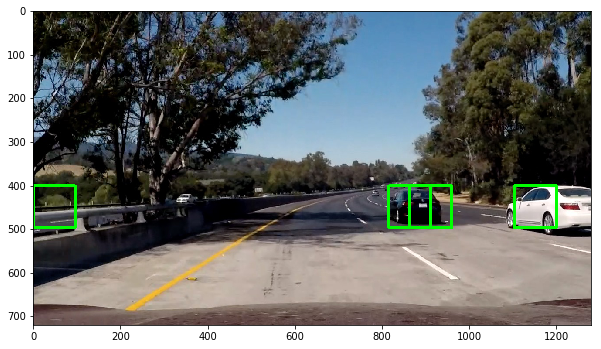

In [48]:
test_img_rects = draw_boxes(test_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Show All Potential Search Areas

Becuase the size and position of cars in the image will be different depending on their distance from the camera, find_cars will have to be called a few times with different ystart, ystop, and scale values. These next few blocks of code are for determining the values for these parameters that work best.

Number of boxes:  78


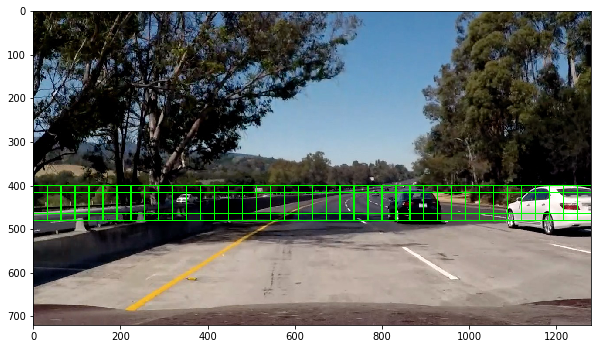

In [39]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 464
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 416
ystop = 480
scale = 1.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  50


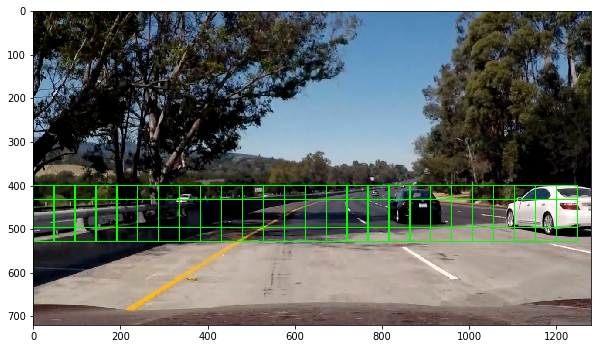

In [40]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 496
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 528
scale = 1.5
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  38


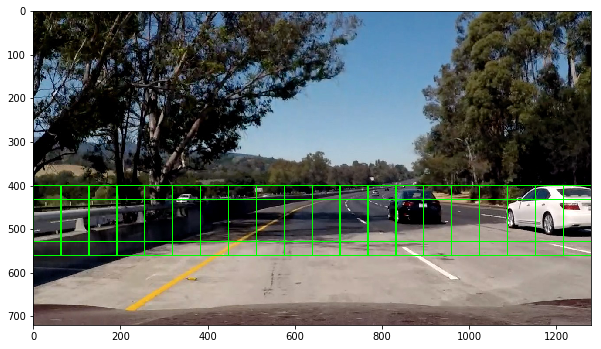

In [41]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 528
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 432
ystop = 560
scale = 2.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

Number of boxes:  24


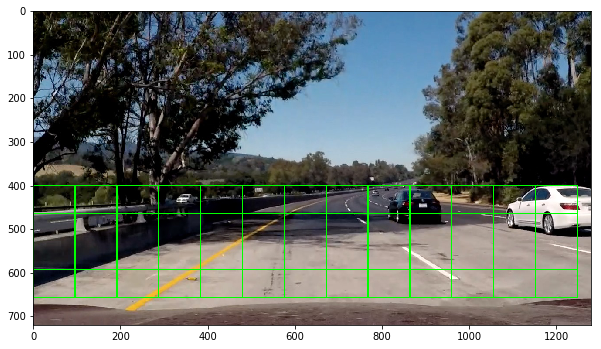

In [42]:
test_img = mpimg.imread('./test_images/test5.jpg')

rects = []

ystart = 400
ystop = 596
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))
ystart = 464
ystop = 660
scale = 3.0
rects.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None, show_all_rectangles=True))

rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
print('Number of boxes: ', len(rectangles))

### Combine Various Sliding Window Searches

Combine all the above tried scales and ystart and ystop values on the test image

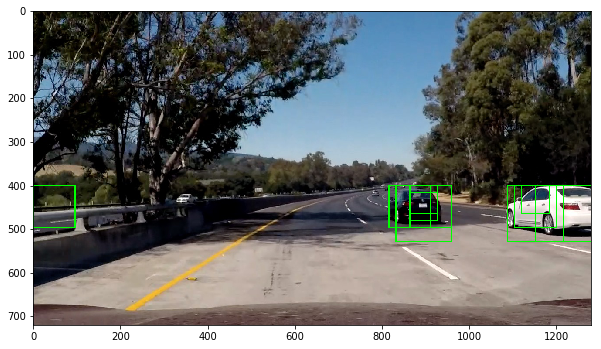

In [43]:
test_img = mpimg.imread('./test_images/test5.jpg')

rectangles = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 416
ystop = 480
scale = 1.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 496
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 528
scale = 1.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 528
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 432
ystop = 560
scale = 2.0
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 400
ystop = 596
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))
ystart = 464
ystop = 660
scale = 3.5
rectangles.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                       orient, pix_per_cell, cell_per_block, None, None))

# apparently this is the best way to flatten a list of lists
rectangles = [item for sublist in rectangles for item in sublist] 
test_img_rects = draw_boxes(test_img, rectangles, color=(0,255,0), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Heatmap

Using heatmap with a threshold to remove false positives

In [44]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

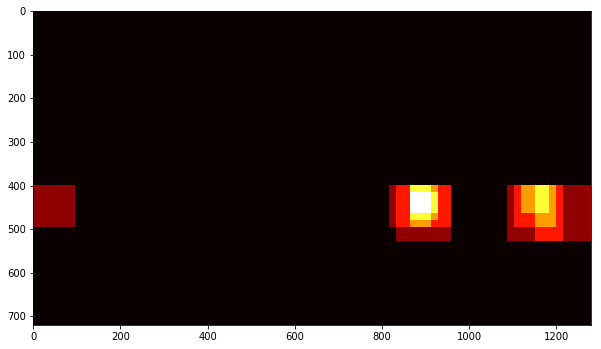

In [45]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


### Apply a Threshold to the Heatmap

In [49]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

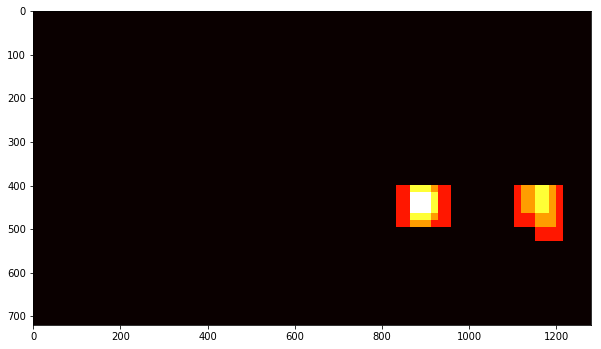

In [50]:
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

### Apply SciPy Labels to Heatmap

2 cars found


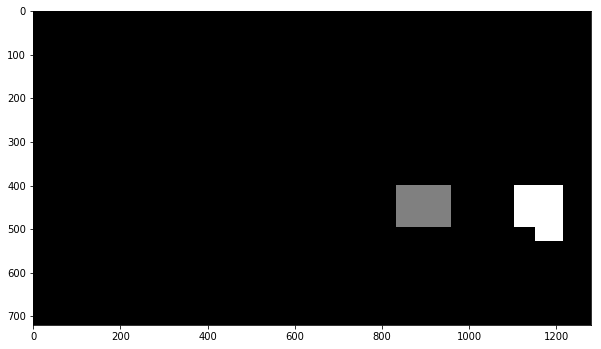

In [51]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

### Draw Bounding Boxes for Lables

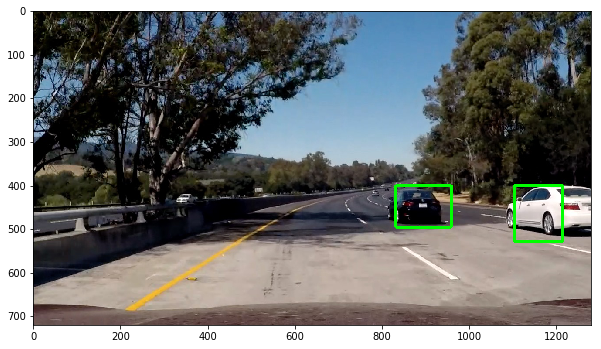

In [52]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image and final rectangles
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)

### Putting it all together - Build a pipeline to test the vehicle detection on test images

In [53]:
def process_frame(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img, rects = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

#### Run the pipeline on all test images

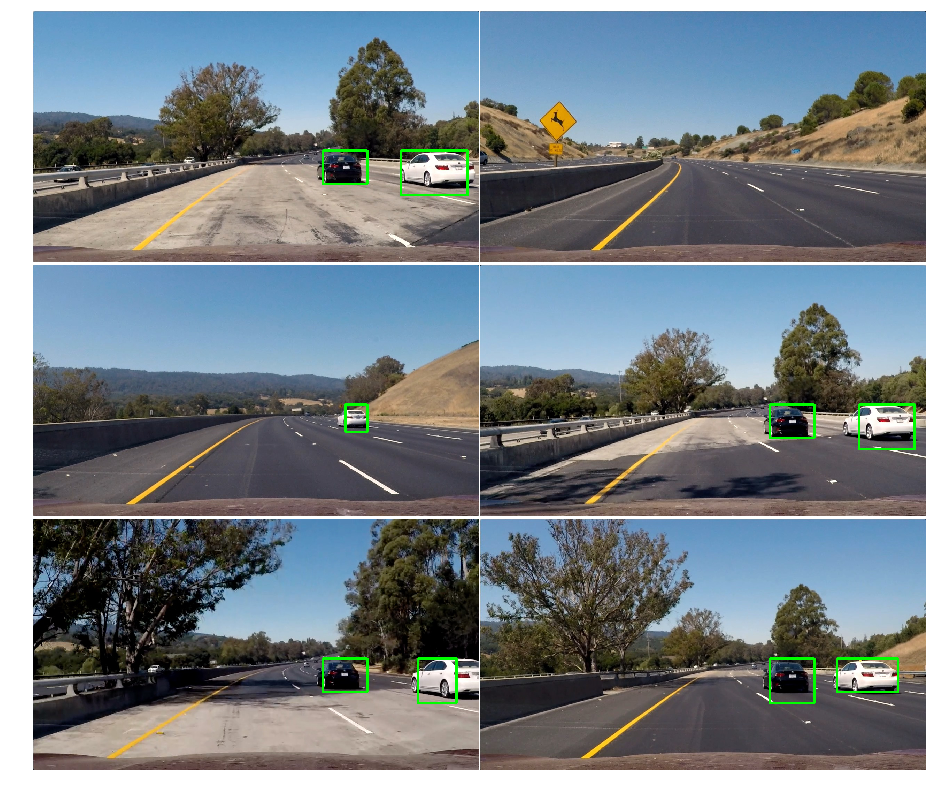

In [54]:
test_images = glob.glob('./test_images/test*.jpg')

fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_frame(mpimg.imread(im)))
    axs[i].axis('off')

### Define a Class to Store Data from Vehicle Detections

In [55]:
# Define a class to store data from video
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]

### Pipeline for Processing Video Frames

In [56]:
def process_frame_for_video(img):

    rectangles = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    ystart = 400
    ystop = 464
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 416
    ystop = 480
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 496
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 528
    scale = 1.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 528
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 432
    ystop = 560
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, 
                           orient, pix_per_cell, cell_per_block, None, None))
 
    rectangles = [item for sublist in rectangles for item in sublist] 
    
    # add detections to the history
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in det.prev_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 1 + len(det.prev_rects)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


### Run a Video Through the Pipeline

In [60]:
det = Vehicle_Detect()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame_for_video)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:12<00:00,  2.79it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 14.5 s


In [61]:
det = Vehicle_Detect()

proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4') 
clip_proj_out = clip_proj.fl_image(process_frame_for_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:17<00:00,  2.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 7min 19s
